# **PHYS 449: Final Project Notebook for Galaxy 10 Analysis**
Reproducing results from "Morphological classification of galaxies with deep learning: comparing 3-way and 4-way CNNs" by Mitchell K. Cavanagh, Kenji Bekki and Brent A. Groves

In this notebook we use the two network architectures written by the aforementioned authors to train on the g-band data from Galaxy10. Galaxy10 contains images of many galaxies from the SDSS which have been labelled. This dataset was authored by Henry Leung, and Jo Bovy at the Department of Astronomy & Astrophysics, University of Toronto. You can find out more here: https://github.com/henrysky/Galaxy10

This notebook was designed to run in Google Colab.

# **Settings for Run**


Here you set up the parameters of the model that you want to run. In order to achieve the combined plot at the bottom with both 3-way and 4-way classificatins you will need to run this notebook twice in a row with a different value for num_class each time.

In [20]:
# can set both to true
run_C1 = True 
run_C2 = True

# can only be 3 or 4
# (rerun the notebook to get both)
num_class = 4

In [21]:
# train, test, validation splits
test_split = 0.15
train_split = 1 - test_split
valid_split = 0.15 # an additional split from test data

In [22]:
input_shape = (69,69,1) # images of 69x69

# **Imports**

In [23]:
!pip install astroNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
# machine learning imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing import image
import tensorflow as tf

# plotting / image imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# sklearn imports
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

# other imports 
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import pickle

In [25]:
# use this if you get SSL error on galaxy10 data download
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# **Setup Galaxy10**

Code and dataset from https://astronn.readthedocs.io/en/latest/galaxy10.html

In [26]:
# ---------------------------------------------------------#
#   astroNN.datasets.galaxy10: galaxy10
# ---------------------------------------------------------#

import os
import urllib.request

import h5py
import numpy as np

from astroNN.config import astroNN_CACHE_DIR
from astroNN.shared.downloader_tools import TqdmUpTo
from astroNN.shared.downloader_tools import sha256_checksum

Galaxy10Class = {0: "Disk, Face-on, No Spiral",
                 1: "Smooth, Completely round",
                 2: "Smooth, in-between round",
                 3: "Smooth, Cigar shaped",
                 4: "Disk, Edge-on, Rounded Bulge",
                 5: "Disk, Edge-on, Boxy Bulge",
                 6: "Disk, Edge-on, No Bulge",
                 7: "Disk, Face-on, Tight Spiral",
                 8: "Disk, Face-on, Medium Spiral",
                 9: "Disk, Face-on, Loose Spiral"}

_G10_ORIGIN = 'http://astro.utoronto.ca/~bovy/Galaxy10/'


def load_data(flag=None):
    """
    NAME:
        load_data
    PURPOSE:
        load_data galaxy10 data
    INPUT:
        None
    OUTPUT:
        x (ndarray): An array of images
        y (ndarray): An array of answer
    HISTORY:
        2018-Jan-22 - Written - Henry Leung (University of Toronto)
    """

    filename = 'Galaxy10.h5'

    complete_url = _G10_ORIGIN + filename

    datadir = os.path.join(astroNN_CACHE_DIR, 'datasets')
    file_hash = '969A6B1CEFCC36E09FFFA86FEBD2F699A4AA19B837BA0427F01B0BC6DED458AF'  # SHA256

    # Notice python expect sha256 in lowercase

    if not os.path.exists(datadir):
        os.makedirs(datadir)
    fullfilename = os.path.join(datadir, filename)

    # Check if files exists
    if os.path.isfile(fullfilename) and flag is None:
        checksum = sha256_checksum(fullfilename)
        if checksum != file_hash.lower():
            print('File corruption detected, astroNN attempting to download again')
            load_data(flag=1)
        else:
            print(fullfilename + ' was found!')
    elif not os.path.isfile(fullfilename) or flag == 1:
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=complete_url.split('/')[-1]) as t:
            urllib.request.urlretrieve(complete_url, fullfilename, reporthook=t.update_to)
            print(f'Downloaded Galaxy10 successfully to {fullfilename}')
            checksum = sha256_checksum(fullfilename)
            if checksum != file_hash.lower():
                load_data(flag=1)

    with h5py.File(fullfilename, 'r') as F:
        x = np.array(F['images'])
        y = np.array(F['ans'])

    return x, y


def galaxy10cls_lookup(class_num):
    """
    NAME:
        galaxy10cls_lookup
    PURPOSE:
        look up class name for Galaxy10
    INPUT:
        class_num (int): An integer 0-9
    OUTPUT:
        (string): Name of the class
    HISTORY:
        2018-Feb-07 - Written - Henry Leung (University of Toronto)
    """
    if isinstance(class_num, list) or isinstance(class_num, np.ndarray):
        class_num = np.argmax(class_num)
    if 0 > class_num or 9 < class_num:
        raise ValueError(f'Galaxy10 only has 10 classes, you entered {class_num}')
    return Galaxy10Class[class_num]


def galaxy10_confusion(confusion_mat):
    """
    NAME:
        galaxy10_confusion
    PURPOSE:
        to plot confusion matrix
    INPUT:
        confusion_mat (ndarray): An integer 0-9
    OUTPUT:
        (string): Name of the class
    HISTORY:
        2018-Feb-11 - Written - Henry Leung (University of Toronto)
    """
    import pylab as plt

    conf_arr = confusion_mat.astype(int)

    norm_conf = []
    a = np.max(conf_arr)
    for i in conf_arr:
        tmp_arr = []
        for j in i:
            tmp_arr.append(float(j) / float(a))
        norm_conf.append(tmp_arr)

    fig, ax = plt.subplots(1, figsize=(10, 10.5), dpi=100)
    fig.suptitle("Confusion Matrix for Galaxy10 trained by astroNN", fontsize=18)
    ax.set_aspect(1)
    ax.imshow(np.array(norm_conf), cmap=plt.get_cmap('Blues'), interpolation='nearest')

    width, height = conf_arr.shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')

    alphabet = '0123456789'
    plt.xticks(range(width), alphabet[:width], fontsize=20)
    plt.yticks(range(height), alphabet[:height], fontsize=20)
    ax.set_ylabel('Prediction class by astroNN', fontsize=18)
    ax.set_xlabel('True class', fontsize=18)
    fig.tight_layout(rect=[0, 0.00, 0.8, 0.96])
    fig.show()

    return None

#----------------------------------------#
#----------------------------------------#
#----------------------------------------#

# **Load Data**
Load Galaxy images and morphology labels labels

In [27]:
images, labels = load_data()
print('l shape before =', labels.shape)
print(labels)

/root/.astroNN/datasets/Galaxy10.h5 was found!
l shape before = (21785,)
[2 2 4 ... 2 9 2]


In [28]:
labels = labels.astype(np.float32)
print('label shape before =', labels.shape)
labels = tf.keras.utils.to_categorical(labels)
print('l shape after =', labels.shape)
images = images.astype(np.float32)
print('i shape before =', images.shape)
images = images/255
print('i shape after =', images.shape)

label shape before = (21785,)
l shape after = (21785, 10)
i shape before = (21785, 69, 69, 3)
i shape after = (21785, 69, 69, 3)


# **Condense Classes**
The galaxy10 playlist natively has 10 classes but we can condense this into 3 or 4

In [29]:
if num_class == 4:
  #This takes the old labels with 10 classes and turns it into 4
  elliptical = [1,2,3]
  lenticular = [4,5,6]
  spiral = [7,8,9]
  irregular = [0]
  name = [0,1,2,3]

  def change_class4(lable):
      label_num_pos = int(np.where(lable==1)[0])
      if label_num_pos in elliptical:
          new_name = np.array([1.,0.,0.,0.])
      if label_num_pos in lenticular:
          new_name = np.array([0.,1.,0.,0.])
      if label_num_pos in spiral:
          new_name = np.array([0.,0.,1.,0.])
      if label_num_pos in irregular:
          new_name = np.array([0.,0.,0.,1.])
      return new_name
  new_labels = np.array([change_class4(labels[i]) for i in range(len(labels))])

elif num_class == 3:
  #This takes the old labels with 10 classes and turns it into 3
  elliptical = [1,2,3]
  lenticular = [4,5,6]
  spiral = [7,8,9,0]
  name = [0,1,2]

  def change_class3(lable):
      label_num_pos = int(np.where(lable==1)[0])
      if label_num_pos in elliptical:
          new_name = np.array([1.,0.,0.])
      if label_num_pos in lenticular:
          new_name = np.array([0.,1.,0.])
      if label_num_pos in spiral:
          new_name = np.array([0.,0.,1.])
      return new_name

  new_labels = np.array([change_class3(labels[i]) for i in range(len(labels))])

In [30]:
# only take one layer (specifically the g-band one)
images = images[:,:,:,0]
print(images.shape)

(21785, 69, 69)


In [31]:
# number of images in each label
label_categor_nums = [int(np.where(new_labels[i]==1)[0]) for i in range(len(new_labels))]
name_occur = [label_categor_nums.count(name[i]) for i in range(len(name))]

# this shows the amount in each label
print(name_occur)

[13638, 2140, 2546, 3461]


# **Data Split**
Split data into training and test sets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(images, new_labels, test_size = test_split)
print(X_train.shape)
print(y_train.shape)

(18517, 69, 69)
(18517, 4)


# **CNN Models**

In [33]:
def C1(input_shape, unique_labels=num_class, dropout_rate=0.5):
    '''
    Defines the 2D Convolutional Neural Network (CNN) called C1
    Parameters:    
    
        input_shape (arr): input shape for network
        unique_labels (int): number unique labels 
        dropout_rate (float): dropout rate as fraction

    Returns:
        
        model (keras model class): CNN to train
    '''

    model = Sequential()

    model.add(Conv2D(filters=32, input_shape=input_shape, activation='relu', kernel_size=(5,5)))
    model.add(Conv2D(filters=64, input_shape=input_shape, activation='relu', kernel_size=(5,5)))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(unique_labels, activation='softmax')) 

    return model

In [34]:
def C2(input_shape, unique_labels=num_class, dropout_rate=0.5):
    '''
    Defines the 2D Convolutional Neural Network (CNN) called C2
    Parameters:    
    
        input_shape (arr): input shape for network
        unique_labels (int): number unique labels 
        dropout_rate (float): dropout rate as fraction

    Returns:
        
        model (keras model class): CNN to train
    '''
    
    model = Sequential()

    model.add(Conv2D(filters=32, input_shape=input_shape, activation='relu', kernel_size=(7,7)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, input_shape=input_shape, activation='relu', kernel_size=(5,5)))
    model.add(Conv2D(filters=64, input_shape=input_shape, activation='relu', kernel_size=(5,5)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, input_shape=input_shape, activation='relu', kernel_size=(3,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))

    model.add(Dense(unique_labels, activation='softmax')) 

    return model

# **Begin Training**

In [35]:
if run_C1:
  
  n_epochs = 13
  lr = 2*pow(10,-4)
  opt = keras.optimizers.Adam(learning_rate=lr) 

  c1_model = C1(input_shape)
  c1_model.summary()

  c1_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  if num_class == 3:
    c1_3_classifier = c1_model.fit(X_train, y_train, epochs=n_epochs, validation_split=valid_split)  
  elif num_class == 4:
    c1_4_classifier = c1_model.fit(X_train, y_train, epochs=n_epochs, validation_split=valid_split)  

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 65, 65, 32)        832       
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        51264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dropout_2 (Dropout)         (None, 57600)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               14745856  
                                                      

In [36]:
if run_C2:

  n_epochs = 20
  lr = 2*pow(10,-4)
  opt = keras.optimizers.Adam(learning_rate=lr)

  c2_model = C2(input_shape)
  c2_model.summary()
  
  c2_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  if num_class == 3:
    c2_3_classifier = c2_model.fit(X_train, y_train, epochs=n_epochs, validation_split=valid_split)  
  elif num_class == 4:
    c2_4_classifier = c2_model.fit(X_train, y_train, epochs=n_epochs, validation_split=valid_split)  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 63, 63, 32)        1600      
                                                                 
 batch_normalization_3 (Batc  (None, 63, 63, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 27, 27, 64)        51264     
                                                                 
 conv2d_10 (Conv2D)          (None, 23, 23, 64)        102464    
                                                                 
 batch_normalization_4 (Batc  (None, 23, 23, 64)      

# **Save Model**
This is optional so has been commented out for now. If you run it you will need to specify which model you want to save and under what file name.

In [37]:
# save the model 
#keras_c2_galaxy10_4cl = 'model_name.sav'
#pickle.dump(model, open(keras_c2_galaxy10_4cl, 'wb'))

# **Plot Results**
A confusion matrix for the test set is plotted below

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,10
rcParams.update({'font.size': 15})

In [41]:
if num_class == 3:
  ### C2 Confusion Matrix ###
  predictions = c2_model.predict(X_test)
  predictions = (predictions > 0.5) 
  labels = ['E', 'S0', 'Sp', 'Irr']

  cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1), normalize='true')#vs pred
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('C2 Confusion Matrix')
  plt.show()

  results = c2_model.evaluate(X_test, y_test)
  print("C2 --> test loss, test acc:", results)

  ### C1 Confusion Matrix ###
  predictions = c1_model.predict(X_test)
  predictions = (predictions > 0.5) 
  labels = ['E', 'S0', 'Sp', 'Irr']

  cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1), normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('C1 Confusion Matrix')
  plt.show()

  results = c1_model.evaluate(X_test, y_test)
  print("C2 --> test loss, test acc:", results)

103/103 [==============================] - 0s 4ms/step


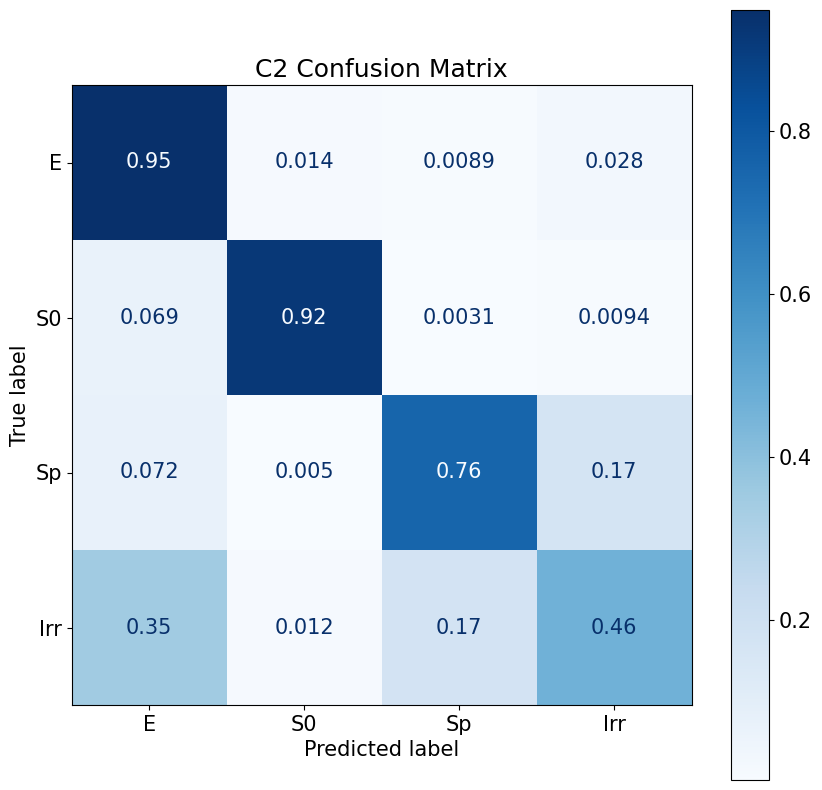

103/103 [==============================] - 0s 5ms/step - loss: 0.4587 - accuracy: 0.8433
C2 --> test loss, test acc: [0.4586699306964874, 0.8433292508125305]
103/103 [==============================] - 1s 5ms/step


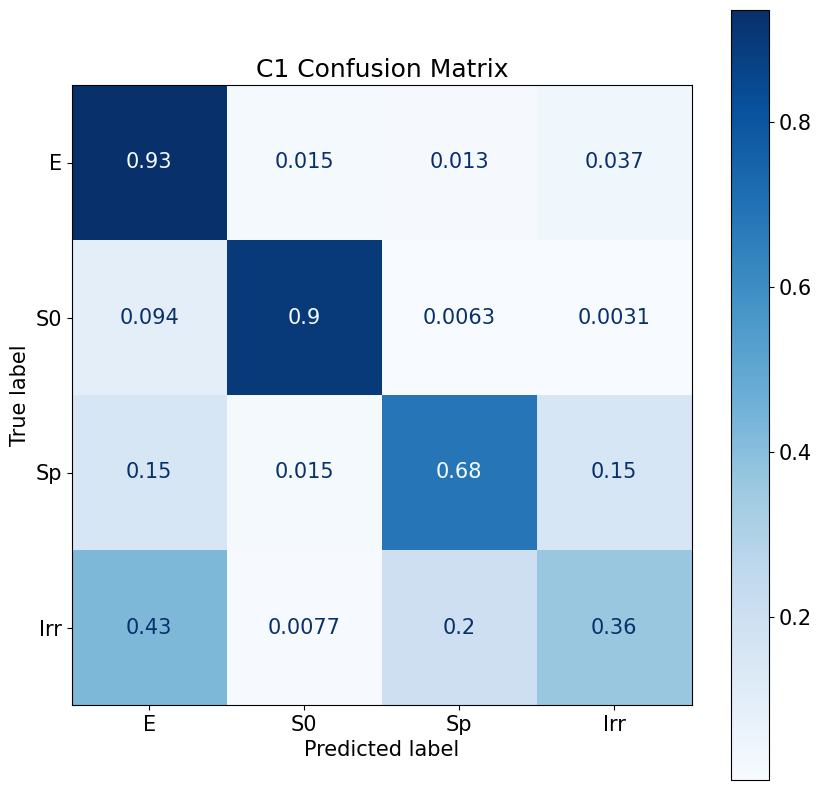

103/103 [==============================] - 1s 6ms/step - loss: 0.5182 - accuracy: 0.8152
C2 --> test loss, test acc: [0.5182260274887085, 0.8151775002479553]


In [42]:
if num_class == 4:
  ### C2 Confusion Matrix ###
  predictions = c2_model.predict(X_test)
  predictions = (predictions > 0.5)

  #labels = ["elliptical", "lenticular", "spiral", "irregular"]
  labels = ['E', 'S0', 'Sp', 'Irr']

  cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1), normalize='true')#vs pred
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('C2 Confusion Matrix')
  plt.show()

  results = c2_model.evaluate(X_test, y_test)
  print("C2 --> test loss, test acc:", results)

  ### C1 Confusion Matrix ###
  predictions = c1_model.predict(X_test)
  predictions = (predictions > 0.5) 
  labels = ['E', 'S0', 'Sp', 'Irr']

  cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1), normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('C1 Confusion Matrix')
  plt.show()

  results = c1_model.evaluate(X_test, y_test)
  print("C2 --> test loss, test acc:", results)


Training & validation loss and accuracy are plotted below. To get the following plot to work correctly you will now need to go back and rerun the notebook for the num_class value different than what is currently set.

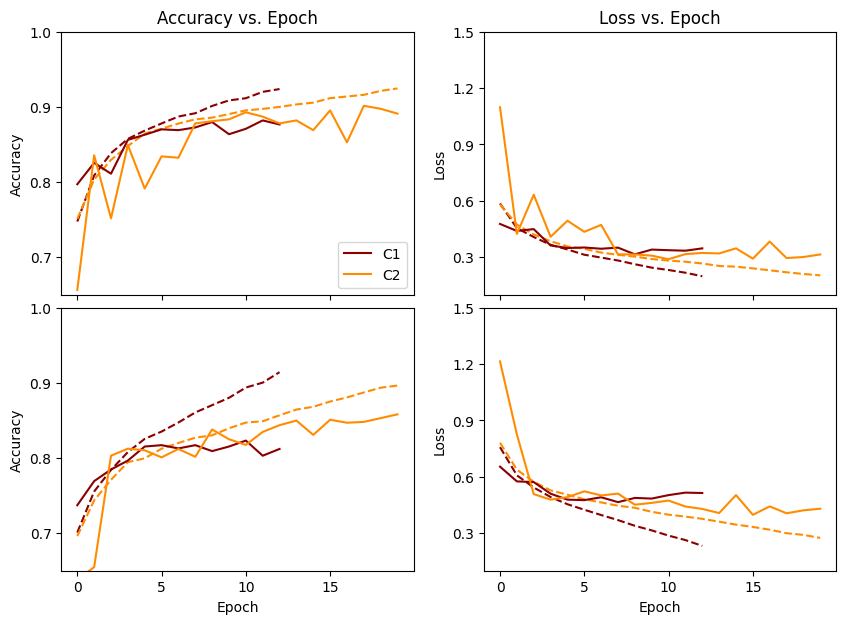

In [43]:
# plot accuracy/loss versus epoch
plt.rcParams.update(plt.rcParamsDefault)
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10, 7))

axs[0, 0].plot(c1_3_classifier.history['accuracy'], '--', color='darkred')
axs[0, 0].plot(c2_3_classifier.history['accuracy'], '--', color='darkorange')
axs[0, 0].plot(c1_3_classifier.history['val_accuracy'], label='C1', color='darkred')
axs[0, 0].plot(c2_3_classifier.history['val_accuracy'], label='C2', color='darkorange')
axs[0, 0].set_title('Accuracy vs. Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_ylim(0.65, 0.98)
axs[0, 0].legend(loc='lower right')

axs[0, 1].plot(c1_3_classifier.history['loss'], '--', color='darkred')
axs[0, 1].plot(c2_3_classifier.history['loss'], '--', color='darkorange')
axs[0, 1].plot(c1_3_classifier.history['val_loss'], label='C1', color='darkred')
axs[0, 1].plot(c2_3_classifier.history['val_loss'], label='C2', color='darkorange')
axs[0, 1].set_title('Loss vs. Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_ylim(0.1, 1.5)

axs[1, 0].plot(c1_4_classifier.history['accuracy'], '--', color='darkred')
axs[1, 0].plot(c2_4_classifier.history['accuracy'], '--', color='darkorange')
axs[1, 0].plot(c1_4_classifier.history['val_accuracy'], label='C1', color='darkred')
axs[1, 0].plot(c2_4_classifier.history['val_accuracy'], label='C2', color='darkorange')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_ylim(0.65, 0.98)

axs[1, 1].plot(c1_4_classifier.history['loss'], '--', color='darkred')
axs[1, 1].plot(c2_4_classifier.history['loss'], '--', color='darkorange')
axs[1, 1].plot(c1_4_classifier.history['val_loss'], label='C1', color='darkred')
axs[1, 1].plot(c2_4_classifier.history['val_loss'], label='C2', color='darkorange')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_ylim(0.1, 1.5)

fig.set_facecolor("white")
plt.subplots_adjust(hspace=0.05) 

axs[0, 0].set_yticks([0.7, 0.8, 0.9, 1])
axs[1, 0].set_yticks([0.7, 0.8, 0.9, 1])
axs[0, 1].set_yticks([0.3, 0.6, 0.9, 1.2, 1.5])
axs[1, 1].set_yticks([0.3, 0.6, 0.9, 1.2, 1.5])

plt.show()